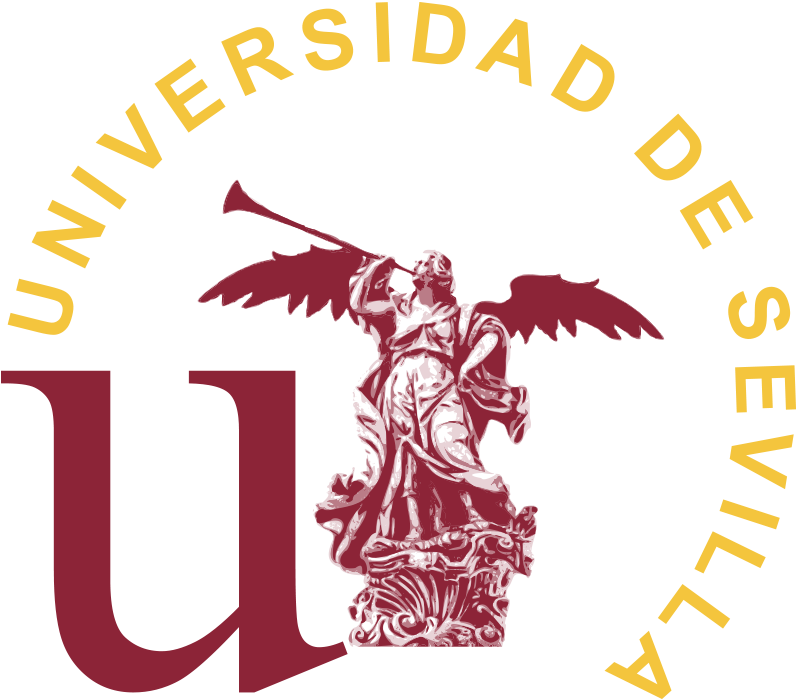

# Visión por computador aplicada a la robótica
## Autores
Alejandro Barranco Ledesma<br>Eliseo Romero Marín

## Configuración inicial
La compatibilidad de Python y en particular Pytorch con dispositivos GPU es algo compleja en la actualidad, por cuestiones de arquitectura hardware. Por ello, se recomienda generar un kernel concreto con una versión de Python estable con las librerías requeridas y una versión de Pytorch y Torchvision compatibles con el dispositivo concreto.

Al realizar este trabajo, para utilizar una NVIDIA GeForce RTX 5060 Laptop GPU fue necesario forzar la versión cu128 (nightly) de Pytorch.

En un **Anaconda prompt**, deben ejecutarse uno a uno estos comandos para poder generar con éxito el kernel **Python (yolo_gpu)**.

Si todo ha sido exitoso, ya dentro del notebook debe seleccionarse el kernel **Python (yolo_gpu)**. A continuación, importamos torch y validamos la versión de Torch y su **compatibilidad con el driver/gpu** del sistema utilizado.

In [3]:
import torch

print("Versión Torch: " + torch.__version__)
print("Versión CUDA: " + torch.version.cuda)
print("Torch detecta CUDA: " + str(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Dispositivo GPU: " + torch.cuda.get_device_name(0))

Versión Torch: 2.11.0.dev20260112+cu128
Versión CUDA: 12.8
Torch detecta CUDA: True
Dispositivo GPU: NVIDIA GeForce RTX 5060 Laptop GPU


## YOLO - Modelo preentrenado (COCO)

El **modelo YOLO** (You Only Look Once) es un modelo de detección de objetos de propósito general que **se distribuye comúnmente preentrenado** lo que permite su uso inmediato sin necesidad de entrenar desde cero. En particular, las implementaciones modernas como **Ultralytics YOLO** se proporcionan con **pesos preentrenados sobre el dataset COCO** (Common Objects in Context), un conjunto de datos a gran escala que contiene más de 300 000 imágenes y 80 clases de objetos de uso cotidiano.

In [17]:
from pathlib import Path

import yaml
import cv2
import time
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [5]:
# Cargar modelo preentrenado
init_model = YOLO("yolo11s.pt")

print(init_model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw


image 1/1 C:\Users\AlejandroBarrancoLed\Desktop\MULCIA\IAR\data\yolo\examples\street-pic01.jpg: 480x640 10 persons, 1 motorcycle, 4 handbags, 42.4ms
Speed: 2.8ms preprocess, 42.4ms inference, 18.2ms postprocess per image at shape (1, 3, 480, 640)


(-0.5, 1199.5, 899.5, -0.5)

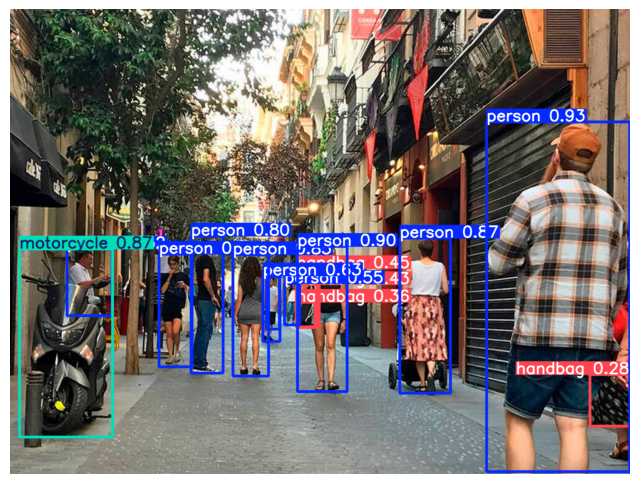

In [6]:
results = init_model("./data/yolo/examples/street-pic01.jpg")
img = results[0].plot() 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")

Los datos de la detección (bboxes, ids, velocidad de procesamiento...) pueden obtenerse de forma trivial. Esto es especialmente útil para **integrarlos en sistemas de robótica**.

In [7]:
results[0].boxes.xyxy # bboxes de elementos detectados (píxeles)

tensor([[ 922.9601,  218.5280, 1199.4867,  895.5497],
        [ 556.9616,  459.8783,  652.5576,  740.4297],
        [ 754.6540,  443.5209,  852.2239,  743.5964],
        [  18.6744,  464.6361,  198.1296,  828.5161],
        [ 431.8915,  475.8654,  500.0650,  710.1526],
        [ 288.1063,  474.5578,  352.8997,  692.0826],
        [ 350.3681,  439.2914,  412.2476,  704.7971],
        [ 489.3235,  516.5438,  522.7703,  643.1669],
        [ 531.2567,  531.2083,  560.6080,  611.9001],
        [ 110.6049,  464.2128,  197.0030,  593.6518],
        [ 554.4264,  502.2009,  598.2629,  615.8519],
        [ 554.1124,  533.0031,  594.4446,  615.7940],
        [ 554.4608,  567.1467,  590.3625,  616.2880],
        [1122.0775,  707.1537, 1200.0000,  807.7694],
        [ 496.1837,  518.3201,  521.9596,  619.9260]], device='cuda:0')

In [8]:
results[0].boxes.cls # clase de elementos detectados (id)

tensor([ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0., 26., 26., 26., 26.,  0.], device='cuda:0')

In [9]:
print([init_model.names[int(n)] for n in results[0].boxes.cls]) # clase de elementos detectados (nombre)

['person', 'person', 'person', 'motorcycle', 'person', 'person', 'person', 'person', 'person', 'person', 'handbag', 'handbag', 'handbag', 'handbag', 'person']


In [10]:
results[0].boxes.conf # confianza de cada detección

tensor([0.9289, 0.8967, 0.8739, 0.8673, 0.8513, 0.8346, 0.7955, 0.6282, 0.5505, 0.5172, 0.4507, 0.4327, 0.3577, 0.2778, 0.2734], device='cuda:0')

## YOLO - Dataset personalizado

Gracias al preentrenamiento en COCO, YOLO tiene desde el inicio una sólida capacidad para detectar patrones visuales generales como bordes, texturas, formas y objetos comunes, lo que lo hace un buen punto de partida para entrenamiento (pesos iniciales). Esto permite utilizar el modelo como punto de partida para fine-tuning sobre datasets específicos, reduciendo significativamente el tiempo de entrenamiento y la cantidad de datos necesarios.

**Dataset utilizado: HomeObjects-3K**

El dataset HomeObjects-3K es un conjunto de datos de detección de objetos diseñado para entornos indoor, especialmente orientado a aplicaciones de robótica móvil y robótica de servicio. El dataset contiene imágenes de escenas domésticas reales con anotaciones en formato YOLO, lo que permite su uso directo en modelos de detección de objetos en tiempo real sin necesidad de realizar conversiones adicionales.

Este dataset incluye 12 clases de objetos comunes en entornos domésticos, entre las que se encuentran: bed, sofa, chair, table, lamp, tv, laptop, wardrobe, window, door, potted plant y photo frame. Estas clases son especialmente relevantes para tareas de percepción visual en robótica indoor, como navegación autónoma, evitación de obstáculos y comprensión del entorno.

El conjunto de datos se encuentra preprocesado y organizado en formato YOLO-ready, con las imágenes y las anotaciones de bounding boxes normalizadas en archivos .txt, compatibles directamente con la librería Ultralytics YOLO.

**División del dataset**

El dataset está dividido en los siguientes subconjuntos:

- Train: conjunto de entrenamiento utilizado para el aprendizaje del modelo, compuesto por aproximadamente 2.285 imágenes.
- Validation (Val): conjunto de validación empleado para evaluar el rendimiento del modelo durante el proceso de entrenamiento y seleccionar el mejor modelo, compuesto por aproximadamente 404 imágenes.
- Test: el dataset no proporciona un conjunto de test independiente. Por este motivo, las métricas de rendimiento se reportan sobre el conjunto de validación, una práctica habitual en trabajos académicos y exploratorios.

Esta división permite entrenar y evaluar modelos de detección de objetos de manera eficiente, manteniendo un equilibrio entre tamaño del dataset, calidad de las anotaciones y estabilidad de las métricas obtenidas.

**Organización local del dataset**

Para este trabajo, el dataset se organiza manualmente dentro del proyecto siguiendo la estructura estándar requerida por YOLO, de modo que las rutas quedan explícitas y se evita cualquier descarga automática durante el entrenamiento:

```
data/yolo/
  ├─ datasets/
  │   └─ homeobjects-3K/
  │       ├─ images/
  │       │   ├─ train/
  │       │   └─ val/
  │       └─ labels/
  │           ├─ train/
  │           └─ val/
  └─ HomeObjects-3K.yaml
```

El archivo de configuración HomeObjects-3K.yaml define explícitamente la ruta local al dataset mediante el parámetro path, junto con los subconjuntos de entrenamiento y validación, garantizando control total sobre la estructura de datos utilizada y una mayor reproducibilidad experimental.

**Descarga y disponibilidad**

El dataset HomeObjects-3K forma parte del conjunto de datasets oficiales mantenidos por la empresa Ultralytics y es de acceso público y gratuito. En este trabajo se utiliza una copia local del dataset junto con su archivo de configuración YAML, evitando descargas automáticas y haciendo explícita la estructura de datos empleada.

La documentación oficial del dataset se encuentra disponible en el siguiente enlace:  
https://docs.ultralytics.com/datasets/detect/homeobjects-3k/

Descarga:
https://github.com/ultralytics/assets/releases/download/v0.0.0/homeobjects-3K.zip

In [11]:
# Folders
OUT_ROOT = Path("./data/yolo")
RUNS_DIR = OUT_ROOT / "runs"
EXPORT_DIR = OUT_ROOT / "model"  # salida estable
EXPORT_MODEL_NAME = "best_model.pt"    # export modelo
YAML_DATA = OUT_ROOT / "HomeObjects-3K.yaml"

# Entrenamiento
MODEL = "yolo11s" # Modelo a utilizar
IMGSZ = 640 # Ancho de las imágenes
EPOCHS = 100
BATCH = 8
RUN_NAME = "homeobjects_yolo"

In [12]:
def pick_device():
    try:
        import torch
        return 0 if torch.cuda.is_available() else "cpu"
    except Exception:
        return "cpu"

In [5]:
# Train
model = YOLO(MODEL)
results = model.train(
    data=YAML_DATA,
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    device=pick_device(),
    project=str(RUNS_DIR),
    seed=0, # reproducible
    exist_ok=True,
    name=RUN_NAME,
    patience=10,
    workers=0,        
    cache=False,      
    verbose=True,
)

New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.10.19 torch-2.11.0.dev20260112+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data\yolo\HomeObjects-3K.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=hom

El entrenamiento ha finalizado por **Early Stopping** al suceder **10 epochs seguidas sin mejorar el rendimiento de validación**, alcanzando el mejor resultado en el **epoch 46**. El mejor resultado se almacena en ./data/yolo/runs/homeobjects_yolo/weights/best.pt. Esto facilita la portabilidad y el uso del modelo entrenado en cualquier otro dispositivo.

También se generan **gráficos de análisis** en ./data/yolo/runs/homeobjects_yolo, como matriz de confusión y evolución de las métricas utilizadas durante el entrenamiento.

<img src="./data/yolo/runs/homeobjects_yolo/results.png"/>
<img src="./data/yolo/runs/homeobjects_yolo/confusion_matrix.png"/>
<img src="./data/yolo/runs/homeobjects_yolo/confusion_matrix_normalized.png"/>

A nivel global, el entrenamiento presenta una **convergencia adecuada**, observándose que las métricas de validación **se estabilizan a partir de los epochs intermedios**. El mejor rendimiento se obtiene en el **epoch 46**, alcanzando aproximadamente **mAP50 = 0.72**, **mAP50-95 = 0.52**, **precisión = 0.76** y **recall = 0.64**. Estos valores se mantienen sin mejoras relevantes en los epochs posteriores, lo que justifica la activación del **Early Stopping** y refleja un **equilibrio razonable entre detecciones correctas y objetos no detectados**.

Respecto a los errores, se observa principalmente una **pérdida de recall**, con varios objetos clasificados como *background*, especialmente en clases como **window** y **lamp**. También aparecen **confusiones entre clases similares** como *chair*, *sofa* y *table*, algo habitual en escenas de interior con objetos próximos o parcialmente ocluidos.

In [13]:
# Cargar modelo preentrenado
model = YOLO("./data/yolo/runs/homeobjects_yolo/weights/best.pt")


image 1/1 C:\Users\AlejandroBarrancoLed\Desktop\MULCIA\IAR\data\yolo\examples\poto-plants.jpg: 640x544 2 potted plants, 29.5ms
Speed: 3.7ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


(-0.5, 1254.5, 1499.5, -0.5)

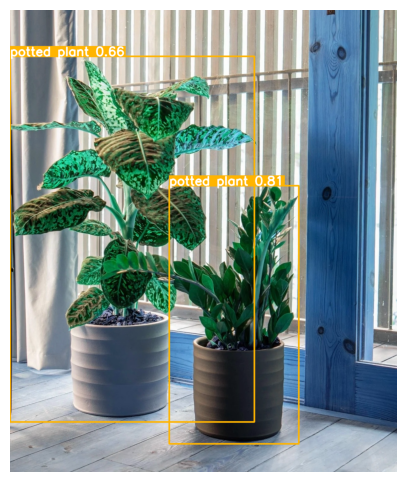

In [14]:
results = model("./data/yolo/examples/poto-plants.jpg")

img = results[0].plot()

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")


image 1/1 C:\Users\AlejandroBarrancoLed\Desktop\MULCIA\IAR\data\yolo\examples\living-room.jpg: 480x640 1 sofa, 2 chairs, 2 tables, 1 lamp, 6 windows, 2 potted plants, 1 photo frame, 26.9ms
Speed: 3.1ms preprocess, 26.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


(-0.5, 1719.5, 1289.5, -0.5)

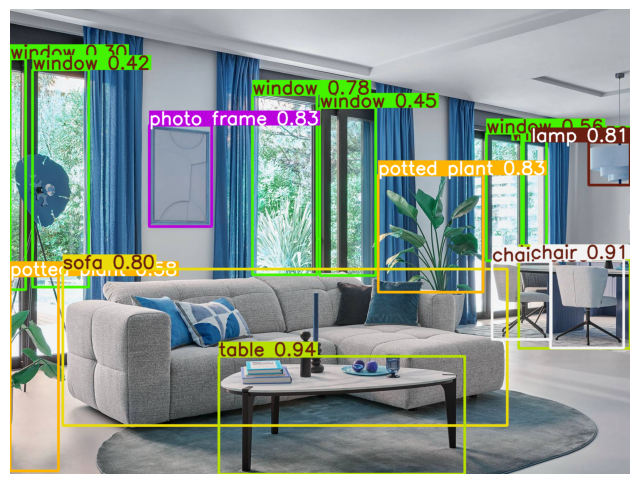

In [15]:
results = model("./data/yolo/examples/living-room.jpg")

img = results[0].plot()

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")

En conjunto, el modelo puede considerarse **bueno y funcional**, mostrando un rendimiento sólido en condiciones favorables (imágenes bien iluminadas y con objetos claramente visibles), aunque con margen de mejora en clases más ambiguas o difíciles.

Podemos observar la predicción correcta de clases como "photo frame", "potted plant" o "table" que **no eran evaluadas previamente** en el modelo inicial preentrenado. 

## YOLO - Detección en tiempo real usando sensor (cámara)

Este bloque inicializa la cámara web y ejecuta un bucle de detección y *tracking* en tiempo real utilizando un modelo YOLO con ByteTrack. Para cada frame capturado se detectan los objetos, se asigna un ID persistente a cada uno y se dibujan sus *bounding boxes*, etiquetas, nivel de confianza y FPS en pantalla. Se establecen variables para ajustar umbrales de confianza e IoU, visualizar el rendimiento en tiempo real y, de forma opcional, guardar el vídeo resultante. La ejecución finaliza al presionar la tecla q.

In [30]:
# Camera
cap = cv2.VideoCapture(1) # elegir id de cámara deseada
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Salvar output
save_video = False
writer = None
video_export_name = "video_yolo.mp4"

conf_thres = 0.50 # threshold
iou_thres  = 0.60 # solapamiento

prev_t = time.time()
fps_smooth = 0.0

# Bucle infinito para detección continua
while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Tracking:
    results = init_model.track(
        frame,
        persist=True,
        tracker="bytetrack.yaml",
        conf=conf_thres,
        iou=iou_thres,
        verbose=False
    )[0]

    annotated = frame.copy()

    # 4) Extraer y dibujar detecciones + IDs
    if results.boxes is not None and len(results.boxes) > 0:
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        clss  = results.boxes.cls.cpu().numpy().astype(int)

        ids_t = results.boxes.id
        ids = ids_t.cpu().numpy().astype(int) if ids_t is not None else [-1] * len(boxes)

        names = results.names  # map id->nombre clase

        for (x1, y1, x2, y2), c, k, tid in zip(boxes, confs, clss, ids):
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            label = f"{names.get(k, str(k))} | ID {tid} | {c:.2f}"

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, label, (x1, max(20, y1 - 8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # FPS (suavizado simple)
    now = time.time()
    fps = 1.0 / max(1e-6, (now - prev_t))
    prev_t = now
    fps_smooth = 0.9 * fps_smooth + 0.1 * fps if fps_smooth > 0 else fps

    cv2.putText(annotated, f"FPS: {fps_smooth:.1f}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

    # Guardar vídeo (opcional)
    if save_video:
        if writer is None:
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")
            h, w = annotated.shape[:2]
            writer = cv2.VideoWriter(video_export_name, fourcc, 30, (w, h))
        writer.write(annotated)

    # Ventana y salida al detectar tecla "q"
    cv2.imshow("YOLO + ByteTrack (q para salir)", annotated)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
if writer is not None:
    writer.release()
cv2.destroyAllWindows()

En el sistema hardware sobre el que se ha implementado, se aprecia un **comportamiento correcto con actualizaciones de detección de 38-40 FPS**, más que **suficiente para ser de utilidad** en sistemas de robótica.

Durante la fase de evaluación se establecieron los valores **conf_thres = 0.50** e **iou_thres = 0.60**, los cuales se fueron ajustando de forma progresiva con el objetivo de **reducir falsos positivos**. Este ajuste resultó especialmente relevante en aquellos casos donde aparecían **elementos sin etiqueta definida**, permitiendo descartar detecciones con baja confianza o solapamientos poco consistentes y mejorando así la fiabilidad global de las predicciones.